In [1]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [3]:
dataset = 'bibx'  #bibx,biby,movielens
# full_X,x,test_mask = helper_func.load_data(dataset)
x = np.loadtxt('../data/eurlex/x_train_sm.txt')
result_folder = "dual_bibtex"
metric = 'mae_nz_all'
users = x.shape[0]
items = x.shape[1]
train_non_zero_indices = helper_func.non_zero_entries(x)
score = []

In [4]:
epochs = 5000000
epochs += 1
test_every = 500000
no_samples_mle = 5000
no_sample_inf = 50
n_trunc = 20
k = 50
param = models.poisson_response(users,items,n_trunc);  # 'ztp' or 'normal'

In [5]:
varpi = 0.1 #looks like 'w^bar' or omega bar
sparsity = 1.0 - float(len(train_non_zero_indices))/(users*items)
em = -np.log(sparsity)
emsq = np.sqrt(em/k)
varrho = 0.1 # looks like mirror inverted q
eta = varrho * emsq  #looks like n
rho =  varrho * varrho  #looks like p
zeta = varpi *emsq #looks like mirror inverted c
omega = varpi * varpi #looks like w
xi = 0.7
tau = 10.0
cutoff_loglik = np.log(1e-6)

In [6]:
t_user = np.ones(shape=users)*tau
t_item = np.ones(shape=items)*tau
ar =  np.ones(shape=users)*(rho+k*eta)   # not fixed in the original code
br = np.ones(shape=users)*(rho/varrho)   
aw = np.ones(shape=items)*(omega+k*zeta)  # not fixed in the original code
bw = np.ones(shape=items)*(omega/varpi)
varphi = np.zeros(k)
a_s = np.ones(shape=[users,k])*eta
bs = np.ones(shape=[users,k])*varrho
av = np.ones(shape=[items,k])*zeta
bv = np.ones(shape=[items,k])*varpi

In [7]:
# curr_loglik = cutoff_loglik -1.0

# while cutoff_loglik > curr_loglik:
#     n_trunc -= 1
#     curr_loglik = n_trunc* np.log(em) - np.log(np.expm1(em)) - math.lgamma(n_trunc + 1);
# n_trunc += 1
# print n_trunc

In [8]:
param.mle_update(train_non_zero_indices,x,no_samples_mle)
del train_non_zero_indices

In [9]:
curr_iter  = 0
while curr_iter <= epochs:
    curr_iter += 1
    u = np.random.randint(low=0,high=users,dtype='int64')
    i = np.random.randint(low=0,high=items,dtype='int64')
    tu = np.power(t_user[u],-xi)
    ti = np.power(t_item[i],-xi)
    
    br[u] = (1.0-tu)*br[u] + tu*(rho/varrho + np.sum(a_s[u,:]/bs[u,:]))
    bs[u,:] = (1.0-tu)*bs[u,:] + tu*(ar[u]/br[u] + items*(av[i,:]/bv[i,:]))
    bw[i] = (1.0-ti)*bw[i] + ti*(omega/varpi + np.sum(av[i,:]/bv[i,:]))
    bv[i,:] = (1.0-ti)*bv[i,:] + ti*(aw[i]/bw[i] + users*(a_s[u,:]/bs[u,:]))
    
    if x[u,i]==0:
        a_s[u,:] = (1.0-tu)*a_s[u,:] + tu*eta
        av[i,:] = (1.0-ti)*av[i,:] + ti*zeta
    else:
        A_ui = np.sum((a_s[u,:]*av[i,:])/(bs[u,:]*bv[i,:]))
        en = param.expectation(x[u,i],A_ui,n_trunc)
        varphi[:]= sp.digamma(a_s[u,:])-np.log(bs[u,:])+sp.digamma(av[i,:])-np.log(bv[i,:])
        log_norm = logsumexp(varphi[:])
        varphi[:] = np.exp(varphi[:]-log_norm)
        a_s[u,:] = (1.0-tu)*a_s[u,:] + tu*(eta+items*en*varphi[:])
        av[i,:] = (1.0-ti)*av[i,:] + ti*(zeta+users*en*varphi[:])
    
    t_user[u] += 1.0
    t_item[i] += 1.0
    
    if curr_iter%test_every == 0:
        print curr_iter
#         q_theta = Gamma(a_s,bs)
#         q_beta = Gamma(np.transpose(av),np.transpose(bv))
#         beta_sample = q_beta.sample(no_sample_inf).eval()
#         theta_sample = q_theta.sample(no_sample_inf).eval()
#         score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
        A = np.matmul((a_s/bs),(av/bv).transpose())
        en = param.expectation_mat(x,A,n_trunc)
        score.append(helper_func.mae_nz_all(x,param.lam*en))

        gc.collect()

500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000


In [16]:
print param.lam

8.8438229302


In [11]:
# print helper_func.auc_score(test_mask,full_X,a_s,av,bs,bv)

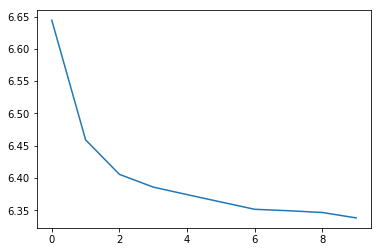

6.3381939119191379

In [12]:
plt.plot(score)
plt.show()
# np.savetxt('../results/'+result_folder+'/'+'hcpf_po_bibx'+metric+'_'+str(k)+'.txt',np.array(score))
min(score)

In [13]:
#print min(score)
#np.savetxt("sampled1.txt",param.sampled,fmt = '%.1f')
#np.savetxt("count.txt",param.temp,fmt = '%.1f')
